## VGG16 
**img shape:(32,32,3)**

In [4]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.io_utils import HDF5Matrix

# base_path = os.path.join('', 'input')
#选取的是灰度图像
train_h5_path = os.path.join(
#     base_path, 
    'food_c101_n10099_r32x32x3.h5')
test_h5_path = os.path.join(
#     base_path, 
    'food_test_c101_n1000_r32x32x3.h5')
%matplotlib inline 

In [5]:
x_train = HDF5Matrix(train_h5_path, 'images')
y_train = HDF5Matrix(train_h5_path, 'category')
print('In Data',x_train.shape,'=>', y_train.shape)
print('data_type:',type(x_train))

In Data (10099, 32, 32, 3) => (10099, 101)
data_type: <class 'keras.utils.io_utils.HDF5Matrix'>


In [6]:
x_test = HDF5Matrix(test_h5_path, 'images',start=0, end=50)
y_test = HDF5Matrix(test_h5_path, 'category',start=0, end=50)
print('In Data',x_test.shape,'=>', y_test.shape)

In Data (50, 32, 32, 3) => (50, 101)


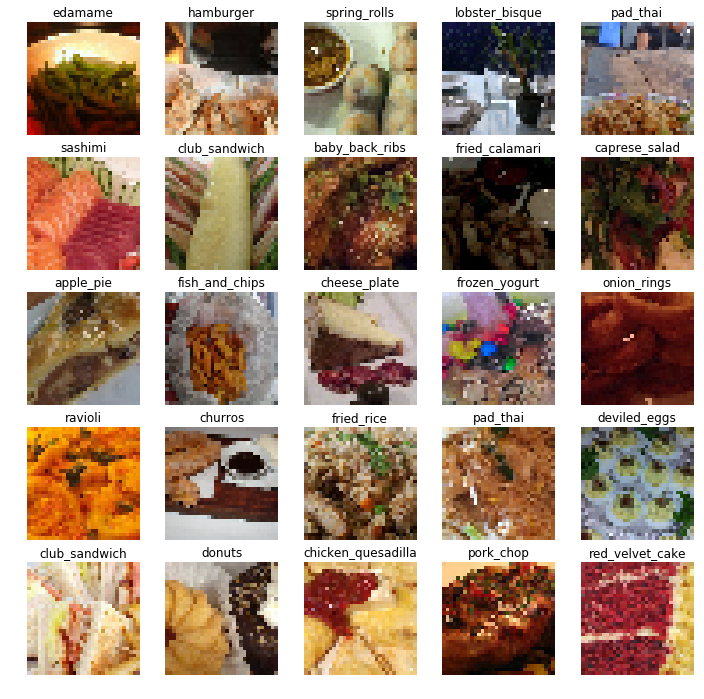

In [7]:
sample_imgs = 25
with h5py.File(train_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
fig, m_ax = plt.subplots(5, 5, figsize = (12, 12))
for c_ax, c_label, c_img in zip(m_ax.flatten(), im_label, im_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title(label_names[np.argmax(c_label)])

In [58]:
import tensorflow as tf

# tf.reset_default_graph()

class Vgg16:
    vgg_mean = [103.939, 116.779, 123.68]

    def __init__(self, vgg16_npy_path=None, restore_from=None):
        # pre-trained parameters
        self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()

        self.tfx = tf.placeholder(tf.float32, [None, 32,32,3])
        self.tfy = tf.placeholder(tf.float32, [None, 101])

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=self.tfx * 255.0)
        bgr = tf.concat(axis=3, values=[
            blue - self.vgg_mean[0],
            green - self.vgg_mean[1],
            red - self.vgg_mean[2],
        ])

        # pre-trained VGG layers are fixed in fine-tune
        conv1_1 = self.conv_layer(bgr, "conv1_1")
        conv1_2 = self.conv_layer(conv1_1, "conv1_2")
        pool1 = self.max_pool(conv1_2, 'pool1')

        conv2_1 = self.conv_layer(pool1, "conv2_1")
        conv2_2 = self.conv_layer(conv2_1, "conv2_2")
        pool2 = self.max_pool(conv2_2, 'pool2')

        conv3_1 = self.conv_layer(pool2, "conv3_1")
        conv3_2 = self.conv_layer(conv3_1, "conv3_2")
        conv3_3 = self.conv_layer(conv3_2, "conv3_3")
        pool3 = self.max_pool(conv3_3, 'pool3')

        conv4_1 = self.conv_layer(pool3, "conv4_1")
        conv4_2 = self.conv_layer(conv4_1, "conv4_2")
        conv4_3 = self.conv_layer(conv4_2, "conv4_3")
        pool4 = self.max_pool(conv4_3, 'pool4')

        conv5_1 = self.conv_layer(pool4, "conv5_1")
        conv5_2 = self.conv_layer(conv5_1, "conv5_2")
        conv5_3 = self.conv_layer(conv5_2, "conv5_3")
        pool5 = self.max_pool(conv5_3, 'pool5')

        # detach original VGG fc layers and
        # reconstruct your own fc layers serve for your own purpose
        shape = pool5.get_shape().as_list() # (ง •_•)ง
        flatten = tf.reshape(pool5,[-1,shape[1]*shape[2]*shape[3]])
        fc6 = tf.layers.dense(flatten, (shape[1]*shape[2]*shape[3])/2, tf.nn.relu,reuse=False)
        self.out = tf.layers.dense(fc6, 101,reuse=False)
        
        # Dropout层
        self.keep_prob = tf.placeholder(tf.float32)
        self.output_drop = tf.nn.dropout(self.out, self.keep_prob)
        
#         self.out = tf.layers.dense(flatten,101)

        self.sess = tf.Session()
        if restore_from:
            saver = tf.train.Saver()
            saver.restore(self.sess, restore_from)
        else:   # training graph
            self.loss = tf.losses.mean_squared_error(labels=self.tfy, predictions=self.output_drop)  ###
            self.train_op = tf.train.RMSPropOptimizer(0.2).minimize(self.loss)
            
            self.acc = tf.metrics.accuracy(
                labels = tf.argmax(self.tfy,axis = 1),
                predictions = tf.argmax(self.output_drop,axis = 1)  ###
                )[1]
            
            self.init_op = tf.group(
                tf.global_variables_initializer(), 
                tf.local_variables_initializer())
            
            self.sess.run(self.init_op)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):   # CNN's filter is constant, NOT Variable that can be trained
            conv = tf.nn.conv2d(bottom, self.data_dict[name][0], [1, 1, 1, 1], padding='SAME')
            lout = tf.nn.relu(tf.nn.bias_add(conv, self.data_dict[name][1]))
            return lout

    def train(self, x, y):
        self.sess.run(self.train_op, {self.tfx: x, self.tfy: y,self.keep_prob:0.8}) ###

    def accuracy(self, x,y):
        acc_ = self.sess.run(self.acc,{self.tfx: x, self.tfy: y,self.keep_prob:1}) ###
        return acc_

    def save(self, path='./save/transfer_learn'):
        saver = tf.train.Saver()
        saver.save(self.sess, path, write_meta_graph=False)

In [59]:
batch_size = 50

In [60]:
# 要改
def train():

    vgg = Vgg16(vgg16_npy_path='vgg16.npy')
    print('Net built')
    for step in range(501):
        p = (step*batch_size)%10000
        q = ((step+1)*batch_size)%10000
        if p>q:
            q = 10099
        b_x = x_train[p:q]
        b_y = y_train[p:q]
        vgg.train(b_x,b_y)
        
        if step % 50 ==0:
            acc_= vgg.accuracy(x_test,y_test)
            print("Step: %i" % step, "| Accurate: %.8f" % acc_)
            
# 待修改    
#     if step == 500:
#         predictions_2 = tf.argmax(output,axis = 1)
#         labels2 = tf.argmax(tf_y,axis = 1)
#         acc_,predictions_2_ ,output_,labels2_= sess.run([accuracy,predictions_2,output,labels2], feed_dict = {tf_x:x_test[0:20],tf_y:y_test[0:20]})
#         print('predictions_2:', predictions_2_,'output:',output_)
#         print('accuracy:',acc_)
#         print('labels2_:',labels2_)

    vgg.save('./save/transfer_learn')      # save learned fc layers


In [61]:
if __name__ == '__main__':
    train()

Net built
Step: 0 | Accurate: 0.00000000
Step: 50 | Accurate: 0.00000000
Step: 100 | Accurate: 0.00000000
Step: 150 | Accurate: 0.00500000
Step: 200 | Accurate: 0.00800000
Step: 250 | Accurate: 0.01000000
Step: 300 | Accurate: 0.01142857
Step: 350 | Accurate: 0.01000000
Step: 400 | Accurate: 0.01111111
Step: 450 | Accurate: 0.01000000
Step: 500 | Accurate: 0.01090909


### 下面的先不跑

In [ ]:
# 要改  暂时不跑这函数了 不慌改
def eval():
    vgg = Vgg16(vgg16_npy_path='vgg16.npy',
                restore_from='./transfer_learn')
    vgg.predict(
        ['./for_transfer_learning/data/kittycat/000129037.jpg', './for_transfer_learning/data/tiger/391412.jpg'])

In [ ]:
# 验证都可以不跑了 直接在训练中的每50步跑一次
if __name__ == '__main__':
    eval()